In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.initializers import glorot_uniform
import random, os, pickle, copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lstsq
%matplotlib inline
savedir = os.path.join('./save/transfer_learning_cifar5')

Using TensorFlow backend.


# SET UP DATA

In [2]:
def map_to_range(arr):
    narr = np.zeros_like(arr, dtype=np.int64)
    vals = np.unique(arr)
    for i, v in enumerate(vals):
        mask = (arr == v)
        narr[mask] = i
    return narr

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
input_shape = (32, 32, 3)
num_classes = 5

y_test = y_test.astype(np.int64).squeeze()
y_train = y_train.astype(np.int64).squeeze()

# labels found to give roughly equal classification performance
set_1_test_mask = np.isin(y_test, np.array([0, 3, 4, 6, 7])).squeeze()
set_1_train_mask = np.isin(y_train, np.array([0, 3, 4, 6, 7])).squeeze()

set_2_test_mask = np.isin(y_test, np.array([1, 2, 5, 8, 9])).squeeze()
set_2_train_mask = np.isin(y_train, np.array([1, 2, 5, 8, 9])).squeeze()

set_1_train_labels = y_train[set_1_train_mask]
x_train_1 = x_train[set_1_train_mask]
set_1_test_labels = y_test[set_1_test_mask]
x_test_1 = x_test[set_1_test_mask]
set_2_train_labels = y_train[set_2_train_mask]
x_train_2 = x_train[set_2_train_mask]
set_2_test_labels = y_test[set_2_test_mask]
x_test_2 = x_test[set_2_test_mask]

y_train_1 = keras.utils.to_categorical(map_to_range(set_1_train_labels), num_classes)
y_train_2 = keras.utils.to_categorical(map_to_range(set_2_train_labels), num_classes)
y_test_1 = keras.utils.to_categorical(map_to_range(set_1_test_labels), num_classes)
y_test_2 = keras.utils.to_categorical(map_to_range(set_2_test_labels), num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
datagen1 = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )
datagen1.fit(x_train_1)

datagen2= ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )
datagen2.fit(x_train_2)

In [5]:
def set_up_model(trainable=[True, True, True, True]):
    keras.backend.clear_session()
    inputs = Input(shape=input_shape)
    x = Conv2D(4, kernel_size=(7,7), strides=(1, 1), activation='relu', padding='same', trainable=trainable[0])(inputs)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(8, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same', trainable=trainable[1])(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(16, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same', trainable=trainable[2])(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', trainable=trainable[3])(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

# TRAIN MODEL

In [1]:
batch_size = 128
epochs = 250
savedir = os.path.join('./save/transfer_learning_cifar5')

model = set_up_model()

ckpt = ModelCheckpoint(os.path.join(savedir, 'weights_dset1_original.h5'), monitor='val_loss', verbose=0, 
                       save_best_only=True, save_weights_only=False, mode='auto', period=1)
history_dset_1 = model.fit_generator(datagen1.flow(x_train_1, y_train_1, batch_size=batch_size),
                 epochs=epochs,
                 verbose=2,
                 validation_data=(x_test_1, y_test_1),
                 callbacks=[ckpt])
with open(os.path.join(savedir, 'history_dset1_original.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

NameError: name 'os' is not defined

In [9]:
batch_size = 128
epochs = 30
model = set_up_model()
model.load_weights(os.path.join(savedir, 'weights_dset1_original.h5'))
ckpt = ModelCheckpoint(os.path.join(savedir, 'weights_dset1_original.h5'), monitor='val_loss', verbose=0, 
                       save_best_only=True, save_weights_only=False, mode='auto', period=1)
history_dset_1 = model.fit_generator(datagen1.flow(x_train_1, y_train_1, batch_size=batch_size),
                 epochs=epochs,
                 verbose=2,
                 validation_data=(x_test_1, y_test_1),
                 callbacks=[ckpt])
with open(os.path.join(savedir, 'history_dset1_original.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/30
 - 10s - loss: 0.6724 - acc: 0.7512 - val_loss: 0.5929 - val_acc: 0.7838
Epoch 2/30
 - 9s - loss: 0.6667 - acc: 0.7479 - val_loss: 0.5946 - val_acc: 0.7788
Epoch 3/30
 - 9s - loss: 0.6712 - acc: 0.7457 - val_loss: 0.5805 - val_acc: 0.7862
Epoch 4/30
 - 9s - loss: 0.6650 - acc: 0.7536 - val_loss: 0.5869 - val_acc: 0.7834
Epoch 5/30
 - 9s - loss: 0.6712 - acc: 0.7506 - val_loss: 0.6054 - val_acc: 0.7774
Epoch 6/30
 - 9s - loss: 0.6724 - acc: 0.7500 - val_loss: 0.6299 - val_acc: 0.7670
Epoch 7/30
 - 9s - loss: 0.6714 - acc: 0.7520 - val_loss: 0.5887 - val_acc: 0.7880
Epoch 8/30
 - 9s - loss: 0.6699 - acc: 0.7535 - val_loss: 0.6011 - val_acc: 0.7792
Epoch 9/30
 - 9s - loss: 0.6643 - acc: 0.7503 - val_loss: 0.6227 - val_acc: 0.7730
Epoch 10/30
 - 9s - loss: 0.6636 - acc: 0.7508 - val_loss: 0.5971 - val_acc: 0.7810
Epoch 11/30
 - 9s - loss: 0.6723 - acc: 0.7456 - val_loss: 0.5992 - val_acc: 0.7824
Epoch 12/30
 - 9s - loss: 0.6722 - acc: 0.7473 - val_loss: 0.6077 - val_acc: 0.7784


NameError: name 'history' is not defined

In [ ]:
history_dset_1 = history

In [10]:
batch_size = 128
epochs = 250
savedir = os.path.join('./save/transfer_learning_cifar5')

model = set_up_model()

ckpt = ModelCheckpoint(os.path.join(savedir, 'weights_dset2_original.h5'), monitor='val_loss', verbose=0, 
                       save_best_only=True, save_weights_only=False, mode='auto', period=1)
history_dset_2 = model.fit_generator(datagen2.flow(x_train_2, y_train_2, batch_size=batch_size),
                 epochs=epochs,
                 verbose=2,
                 validation_data=(x_test_2, y_test_2),
                 callbacks=[ckpt])
with open(os.path.join(savedir, 'history_dset2_original.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/250
 - 9s - loss: 1.2639 - acc: 0.4576 - val_loss: 1.0257 - val_acc: 0.5770
Epoch 2/250
 - 8s - loss: 1.0294 - acc: 0.5838 - val_loss: 0.9744 - val_acc: 0.6174
Epoch 3/250
 - 8s - loss: 0.9516 - acc: 0.6167 - val_loss: 0.9057 - val_acc: 0.6394
Epoch 4/250
 - 8s - loss: 0.9299 - acc: 0.6284 - val_loss: 0.8755 - val_acc: 0.6500
Epoch 5/250
 - 8s - loss: 0.8977 - acc: 0.6431 - val_loss: 0.8069 - val_acc: 0.6788
Epoch 6/250
 - 8s - loss: 0.8791 - acc: 0.6524 - val_loss: 0.8027 - val_acc: 0.6774
Epoch 7/250
 - 8s - loss: 0.8558 - acc: 0.6608 - val_loss: 0.8195 - val_acc: 0.6768
Epoch 8/250
 - 8s - loss: 0.8423 - acc: 0.6690 - val_loss: 0.7389 - val_acc: 0.7126
Epoch 9/250
 - 8s - loss: 0.8373 - acc: 0.6684 - val_loss: 0.7707 - val_acc: 0.6930
Epoch 10/250
 - 8s - loss: 0.8234 - acc: 0.6791 - val_loss: 0.7830 - val_acc: 0.6908
Epoch 11/250
 - 8s - loss: 0.8209 - acc: 0.6760 - val_loss: 0.7675 - val_acc: 0.6862
Epoch 12/250
 - 8s - loss: 0.8054 - acc: 0.6860 - val_loss: 0.7627 - val_a

Epoch 98/250
 - 8s - loss: 0.5857 - acc: 0.7808 - val_loss: 0.5572 - val_acc: 0.7884
Epoch 99/250
 - 9s - loss: 0.5836 - acc: 0.7778 - val_loss: 0.5604 - val_acc: 0.7898
Epoch 100/250
 - 9s - loss: 0.5840 - acc: 0.7805 - val_loss: 0.5379 - val_acc: 0.7972
Epoch 101/250
 - 8s - loss: 0.5884 - acc: 0.7828 - val_loss: 0.5111 - val_acc: 0.8110
Epoch 102/250
 - 8s - loss: 0.5785 - acc: 0.7846 - val_loss: 0.5882 - val_acc: 0.7808
Epoch 103/250
 - 8s - loss: 0.5743 - acc: 0.7867 - val_loss: 0.5346 - val_acc: 0.7942
Epoch 104/250
 - 8s - loss: 0.5668 - acc: 0.7867 - val_loss: 0.5820 - val_acc: 0.7832
Epoch 105/250
 - 8s - loss: 0.5777 - acc: 0.7850 - val_loss: 0.5546 - val_acc: 0.7938
Epoch 106/250
 - 9s - loss: 0.5691 - acc: 0.7878 - val_loss: 0.5187 - val_acc: 0.8014
Epoch 107/250
 - 9s - loss: 0.5759 - acc: 0.7838 - val_loss: 0.5155 - val_acc: 0.8096
Epoch 108/250
 - 8s - loss: 0.5764 - acc: 0.7819 - val_loss: 0.5494 - val_acc: 0.7912
Epoch 109/250
 - 8s - loss: 0.5686 - acc: 0.7859 - val_l

Epoch 194/250
 - 9s - loss: 0.5281 - acc: 0.8029 - val_loss: 0.5667 - val_acc: 0.7972
Epoch 195/250
 - 9s - loss: 0.5321 - acc: 0.8033 - val_loss: 0.4991 - val_acc: 0.8092
Epoch 196/250
 - 8s - loss: 0.5310 - acc: 0.8042 - val_loss: 0.4984 - val_acc: 0.8066
Epoch 197/250
 - 8s - loss: 0.5336 - acc: 0.8034 - val_loss: 0.5393 - val_acc: 0.8000
Epoch 198/250
 - 8s - loss: 0.5218 - acc: 0.8045 - val_loss: 0.5718 - val_acc: 0.7868
Epoch 199/250
 - 9s - loss: 0.5209 - acc: 0.8061 - val_loss: 0.4948 - val_acc: 0.8082
Epoch 200/250
 - 8s - loss: 0.5238 - acc: 0.8046 - val_loss: 0.4957 - val_acc: 0.8150
Epoch 201/250
 - 9s - loss: 0.5220 - acc: 0.8041 - val_loss: 0.4923 - val_acc: 0.8138
Epoch 202/250
 - 8s - loss: 0.5269 - acc: 0.8022 - val_loss: 0.4670 - val_acc: 0.8228
Epoch 203/250
 - 8s - loss: 0.5253 - acc: 0.8036 - val_loss: 0.4814 - val_acc: 0.8152
Epoch 204/250
 - 8s - loss: 0.5262 - acc: 0.8040 - val_loss: 0.5284 - val_acc: 0.8014
Epoch 205/250
 - 9s - loss: 0.5205 - acc: 0.8076 - val

NameError: name 'history' is not defined

# TRANSFER LEARNING FREEZE FIRST

## From dset1 to dset2

In [ ]:
epochs = 100
batch_size = 128

model = set_up_model(trainable=[False, True, True, True])
model.load_weights(os.path.join(savedir, 'weights_dset1_original.h5'))
orig_weights = model.get_weights()
nweights = copy.deepcopy(orig_weights[:2])
for w in orig_weights[2:]:
    nweights.append(glorot_uniform()(w.shape).eval(session=keras.backend.get_session()))
model.set_weights(nweights)
ckpt_transfer = ModelCheckpoint(os.path.join(savedir, 'weights_dset1_transfer.h5'), monitor='val_loss', verbose=0, 
                       save_best_only=True, save_weights_only=False, mode='auto', period=1)
history_dset1_transfer = model.fit_generator(datagen2.flow(x_train_2, y_train_2, batch_size=batch_size),
                 epochs=epochs,
                 verbose=2,
                 validation_data=(x_test_2, y_test_2),
                 callbacks=[ckpt_transfer])
with open(os.path.join(savedir, 'history_dset1_transfer_dset2.pkl'), 'wb') as f:
    pickle.dump(history_dset1_transfer.history, f)

Epoch 1/100
 - 9s - loss: 1.3273 - acc: 0.4359 - val_loss: 1.0382 - val_acc: 0.5868
Epoch 2/100
 - 8s - loss: 1.0686 - acc: 0.5657 - val_loss: 0.9261 - val_acc: 0.6248
Epoch 3/100
 - 8s - loss: 0.9979 - acc: 0.5949 - val_loss: 0.9277 - val_acc: 0.6284
Epoch 4/100
 - 8s - loss: 0.9663 - acc: 0.6139 - val_loss: 0.8763 - val_acc: 0.6382
Epoch 5/100
 - 8s - loss: 0.9393 - acc: 0.6227 - val_loss: 0.8584 - val_acc: 0.6534
Epoch 6/100
 - 8s - loss: 0.9110 - acc: 0.6371 - val_loss: 0.8278 - val_acc: 0.6746
Epoch 7/100
 - 8s - loss: 0.9035 - acc: 0.6426 - val_loss: 0.7944 - val_acc: 0.6860
Epoch 8/100
 - 8s - loss: 0.8832 - acc: 0.6472 - val_loss: 0.8318 - val_acc: 0.6762
Epoch 9/100
 - 8s - loss: 0.8705 - acc: 0.6567 - val_loss: 0.7603 - val_acc: 0.7008
Epoch 10/100
 - 8s - loss: 0.8621 - acc: 0.6584 - val_loss: 0.7562 - val_acc: 0.7034
Epoch 11/100
 - 8s - loss: 0.8493 - acc: 0.6636 - val_loss: 0.7935 - val_acc: 0.6848
Epoch 12/100
 - 8s - loss: 0.8416 - acc: 0.6673 - val_loss: 0.7756 - val_a

Epoch 98/100
 - 8s - loss: 0.6409 - acc: 0.7521 - val_loss: 0.5709 - val_acc: 0.7846
Epoch 99/100
 - 8s - loss: 0.6366 - acc: 0.7560 - val_loss: 0.5782 - val_acc: 0.7818
Epoch 100/100


## From dset1 to dset1

In [11]:
epochs = 100
batch_size = 128

model = set_up_model(trainable=[False, True, True, True])
model.load_weights(os.path.join(savedir, 'weights_dset1_original.h5'))
orig_weights = model.get_weights()
nweights = copy.deepcopy(orig_weights[:2])
for w in orig_weights[2:]:
    nweights.append(glorot_uniform()(w.shape).eval(session=keras.backend.get_session()))
model.set_weights(nweights)
ckpt_transfer = ModelCheckpoint(os.path.join(savedir, 'weights_dset1_transfer_dset1.h5'), monitor='val_loss', verbose=0, 
                       save_best_only=True, save_weights_only=False, mode='auto', period=1)
history_transfer = model.fit_generator(datagen1.flow(x_train_1, y_train_1, batch_size=batch_size),
                 epochs=epochs,
                 verbose=2,
                 validation_data=(x_test_1, y_test_1),
                 callbacks=[ckpt_transfer])
with open(os.path.join(savedir, 'history_dset1_transfer_dset1.pkl'), 'wb') as f:
    pickle.dump(history_transfer.history, f)

Epoch 1/100
 - 12s - loss: 1.3768 - acc: 0.4139 - val_loss: 1.1666 - val_acc: 0.5178
Epoch 2/100
 - 16s - loss: 1.2027 - acc: 0.5201 - val_loss: 1.0657 - val_acc: 0.5772
Epoch 3/100
 - 16s - loss: 1.1488 - acc: 0.5440 - val_loss: 1.0236 - val_acc: 0.5998
Epoch 4/100
 - 16s - loss: 1.1081 - acc: 0.5610 - val_loss: 0.9940 - val_acc: 0.6140
Epoch 5/100
 - 17s - loss: 1.0867 - acc: 0.5754 - val_loss: 0.9783 - val_acc: 0.6244
Epoch 6/100
 - 17s - loss: 1.0555 - acc: 0.5866 - val_loss: 0.9475 - val_acc: 0.6320
Epoch 7/100
 - 16s - loss: 1.0203 - acc: 0.6006 - val_loss: 0.9223 - val_acc: 0.6470
Epoch 8/100
 - 15s - loss: 0.9977 - acc: 0.6122 - val_loss: 0.8732 - val_acc: 0.6604
Epoch 9/100
 - 16s - loss: 0.9895 - acc: 0.6175 - val_loss: 0.8599 - val_acc: 0.6660
Epoch 10/100
 - 15s - loss: 0.9718 - acc: 0.6292 - val_loss: 0.8459 - val_acc: 0.6734
Epoch 11/100
 - 17s - loss: 0.9478 - acc: 0.6395 - val_loss: 0.8644 - val_acc: 0.6606
Epoch 12/100
 - 16s - loss: 0.9448 - acc: 0.6400 - val_loss: 0.

Epoch 97/100
 - 16s - loss: 0.7542 - acc: 0.7166 - val_loss: 0.6875 - val_acc: 0.7406
Epoch 98/100
 - 15s - loss: 0.7593 - acc: 0.7160 - val_loss: 0.6643 - val_acc: 0.7536
Epoch 99/100
 - 15s - loss: 0.7510 - acc: 0.7167 - val_loss: 0.6631 - val_acc: 0.7556
Epoch 100/100
 - 16s - loss: 0.7561 - acc: 0.7176 - val_loss: 0.6658 - val_acc: 0.7540


NameError: name 'history_transfer_same_0' is not defined

## From dset2 to dset1

In [16]:
epochs = 100
batch_size = 128

model = set_up_model(trainable=[False, True, True, True])
model.load_weights(os.path.join(savedir, 'weights_dset2_original.h5'))
orig_weights = model.get_weights()
nweights = copy.deepcopy(orig_weights[:2])
for w in orig_weights[2:]:
    nweights.append(glorot_uniform()(w.shape).eval(session=keras.backend.get_session()))
model.set_weights(nweights)
ckpt_transfer = ModelCheckpoint(os.path.join(savedir, 'weights_dset2_transfer_dset1.h5'), monitor='val_loss', verbose=0, 
                       save_best_only=True, save_weights_only=False, mode='auto', period=1)
history_dset2_transfer = model.fit_generator(datagen1.flow(x_train_1, y_train_1, batch_size=batch_size),
                 epochs=epochs,
                 verbose=2,
                 validation_data=(x_test_1, y_test_1),
                 callbacks=[ckpt_transfer])
with open(os.path.join(savedir, 'history_dset2_transfer_dset1.pkl'), 'wb') as f:
    pickle.dump(history_dset2_transfer.history, f)

Epoch 1/100
 - 15s - loss: 1.3294 - acc: 0.4288 - val_loss: 1.1547 - val_acc: 0.5424
Epoch 2/100
 - 15s - loss: 1.1438 - acc: 0.5439 - val_loss: 1.0568 - val_acc: 0.5744
Epoch 3/100
 - 16s - loss: 1.0924 - acc: 0.5696 - val_loss: 1.0055 - val_acc: 0.6008
Epoch 4/100
 - 16s - loss: 1.0423 - acc: 0.5945 - val_loss: 0.9746 - val_acc: 0.6090
Epoch 5/100
 - 15s - loss: 1.0193 - acc: 0.6052 - val_loss: 0.9568 - val_acc: 0.6160
Epoch 6/100
 - 16s - loss: 0.9949 - acc: 0.6149 - val_loss: 0.9062 - val_acc: 0.6362
Epoch 7/100
 - 15s - loss: 0.9716 - acc: 0.6222 - val_loss: 0.8914 - val_acc: 0.6472
Epoch 8/100
 - 16s - loss: 0.9605 - acc: 0.6254 - val_loss: 0.8713 - val_acc: 0.6614
Epoch 9/100
 - 18s - loss: 0.9543 - acc: 0.6306 - val_loss: 0.8590 - val_acc: 0.6612
Epoch 10/100
 - 19s - loss: 0.9377 - acc: 0.6383 - val_loss: 0.8589 - val_acc: 0.6614
Epoch 11/100
 - 16s - loss: 0.9289 - acc: 0.6428 - val_loss: 0.8647 - val_acc: 0.6542
Epoch 12/100
 - 17s - loss: 0.9236 - acc: 0.6438 - val_loss: 0.

Epoch 97/100
 - 15s - loss: 0.7508 - acc: 0.7177 - val_loss: 0.6833 - val_acc: 0.7438
Epoch 98/100
 - 15s - loss: 0.7490 - acc: 0.7155 - val_loss: 0.6778 - val_acc: 0.7418
Epoch 99/100
 - 17s - loss: 0.7392 - acc: 0.7196 - val_loss: 0.6619 - val_acc: 0.7534
Epoch 100/100
 - 15s - loss: 0.7429 - acc: 0.7180 - val_loss: 0.6846 - val_acc: 0.7420


## From dset2 to dset2

In [17]:
epochs = 100
batch_size = 128

model = set_up_model(trainable=[False, True, True, True])
model.load_weights(os.path.join(savedir, 'weights_dset2_original.h5'))
orig_weights = model.get_weights()
nweights = copy.deepcopy(orig_weights[:2])
for w in orig_weights[2:]:
    nweights.append(glorot_uniform()(w.shape).eval(session=keras.backend.get_session()))
model.set_weights(nweights)
ckpt_transfer = ModelCheckpoint(os.path.join(savedir, 'weights_dset2_transfer_dset2.h5'), monitor='val_loss', verbose=0, 
                       save_best_only=True, save_weights_only=False, mode='auto', period=1)
history_dset2_transfer = model.fit_generator(datagen2.flow(x_train_2, y_train_2, batch_size=batch_size),
                 epochs=epochs,
                 verbose=2,
                 validation_data=(x_test_2, y_test_2),
                 callbacks=[ckpt_transfer])
with open(os.path.join(savedir, 'history_dset2_transfer_dset2.pkl'), 'wb') as f:
    pickle.dump(history_dset2_transfer.history, f)

Epoch 1/100
 - 12s - loss: 1.2198 - acc: 0.4803 - val_loss: 1.0165 - val_acc: 0.5876
Epoch 2/100
 - 15s - loss: 0.9673 - acc: 0.6114 - val_loss: 0.9048 - val_acc: 0.6386
Epoch 3/100
 - 17s - loss: 0.8981 - acc: 0.6424 - val_loss: 0.8229 - val_acc: 0.6682
Epoch 4/100
 - 16s - loss: 0.8508 - acc: 0.6664 - val_loss: 0.7969 - val_acc: 0.6860
Epoch 5/100
 - 16s - loss: 0.8182 - acc: 0.6798 - val_loss: 0.7727 - val_acc: 0.6986
Epoch 6/100
 - 17s - loss: 0.7988 - acc: 0.6853 - val_loss: 0.7667 - val_acc: 0.7042
Epoch 7/100
 - 16s - loss: 0.7813 - acc: 0.6975 - val_loss: 0.7193 - val_acc: 0.7222
Epoch 8/100
 - 15s - loss: 0.7594 - acc: 0.7033 - val_loss: 0.6987 - val_acc: 0.7328
Epoch 9/100
 - 16s - loss: 0.7473 - acc: 0.7103 - val_loss: 0.7094 - val_acc: 0.7276
Epoch 10/100
 - 16s - loss: 0.7364 - acc: 0.7162 - val_loss: 0.6786 - val_acc: 0.7354
Epoch 11/100
 - 16s - loss: 0.7186 - acc: 0.7222 - val_loss: 0.6558 - val_acc: 0.7482
Epoch 12/100
 - 16s - loss: 0.7095 - acc: 0.7248 - val_loss: 0.

Epoch 97/100
 - 15s - loss: 0.5504 - acc: 0.7936 - val_loss: 0.5012 - val_acc: 0.8120
Epoch 98/100
 - 15s - loss: 0.5600 - acc: 0.7910 - val_loss: 0.5150 - val_acc: 0.8078
Epoch 99/100
 - 16s - loss: 0.5538 - acc: 0.7950 - val_loss: 0.5129 - val_acc: 0.8044
Epoch 100/100
 - 17s - loss: 0.5537 - acc: 0.7914 - val_loss: 0.4931 - val_acc: 0.8152


## Compare accuracies

In [20]:
with open(os.path.join(savedir, 'history_dset1_transfer_dset1.pkl'), 'rb') as f:
    history_dset1_dset1 = pickle.load(f)
with open(os.path.join(savedir, 'history_dset1_transfer_dset2.pkl'), 'rb') as f:
    history_dset1_dset2 = pickle.load(f)
with open(os.path.join(savedir, 'history_dset2_transfer_dset1.pkl'), 'rb') as f:
    history_dset2_dset1 = pickle.load(f)
with open(os.path.join(savedir, 'history_dset2_transfer_dset2.pkl'), 'rb') as f:
    history_dset2_dset2 = pickle.load(f)

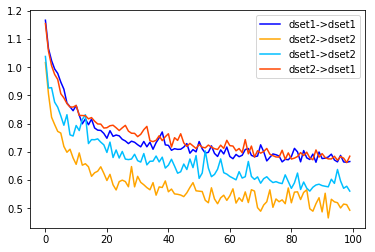

In [26]:
plt.plot(history_dset1_dset1['val_loss'], color='blue', label='dset1->dset1')
plt.plot(history_dset2_dset2['val_loss'], color='orange', label='dset2->dset2')
plt.plot(history_dset1_dset2['val_loss'], color='deepskyblue', label='dset1->dset2')
plt.plot(history_dset2_dset1['val_loss'], color='orangered', label='dset2->dset1')
plt.legend()

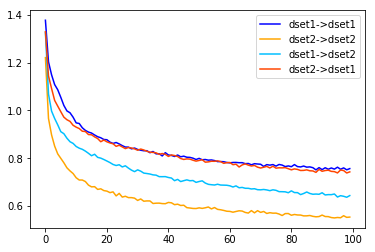

In [27]:
plt.plot(history_dset1_dset1['loss'], color='blue', label='dset1->dset1')
plt.plot(history_dset2_dset2['loss'], color='orange', label='dset2->dset2')
plt.plot(history_dset1_dset2['loss'], color='deepskyblue', label='dset1->dset2')
plt.plot(history_dset2_dset1['loss'], color='orangered', label='dset2->dset1')
plt.legend()

In [9]:
def get_accuracy(weights, x, y):
    model = set_up_model()
    model.load_weights(weights)
    preds = model.predict(x)
    acc = (preds.argmax(axis=1) == y.argmax(axis=1)).mean()
    return acc

In [10]:
acc_dset1_original = get_accuracy(os.path.join(savedir, 'weights_dset1_original.h5'), x_test_1, y_test_1)
acc_dset2_original = get_accuracy(os.path.join(savedir, 'weights_dset2_original.h5'), x_test_2, y_test_2)
acc_dset1_dset1 = get_accuracy(os.path.join(savedir, 'weights_dset1_transfer_dset1.h5'), x_test_1, y_test_1)
acc_dset1_dset2 = get_accuracy(os.path.join(savedir, 'weights_dset1_transfer_dset2.h5'), x_test_2, y_test_2)
acc_dset2_dset2 = get_accuracy(os.path.join(savedir, 'weights_dset2_transfer_dset2.h5'), x_test_2, y_test_2)
acc_dset2_dset1 = get_accuracy(os.path.join(savedir, 'weights_dset2_transfer_dset1.h5'), x_test_1, y_test_1)

In [13]:
print('dset1_original: ', acc_dset1_original)
print('dset2_original: ', acc_dset2_original)
print('dset1 -> dset2: ', acc_dset1_dset2)
print('dset1 -> dset1: ', acc_dset1_dset1)
print('dset2 -> dset1: ', acc_dset2_dset1)
print('dset2 -> dset2: ', acc_dset2_dset2)

dset1_original:  0.7862
dset2_original:  0.8304
dset1 -> dset2:  0.7858
dset1 -> dset1:  0.7556
dset2 -> dset1:  0.7534
dset2 -> dset2:  0.8208
